<a href="https://colab.research.google.com/github/Mikcl/CellTransformer/blob/wip-no-repeat/Cells_are_Transformers_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install linear-attention-transformer
!pip install einops

  Created wheel for axial-positional-embedding: filename=axial_positional_embedding-0.2.1-cp37-none-any.whl size=2905 sha256=8c3f1e3dd4a46df72eb8973cbe973913a21f9f51dcbd5ce825d6459bff170c3b
  Stored in directory: /root/.cache/pip/wheels/cd/f8/93/25b60e319a481e8f324dcb1871aff818eb0c8143ed20b732b4
  Created wheel for product-key-memory: filename=product_key_memory-0.1.10-cp37-none-any.whl size=3072 sha256=deb276c7da80de66ba90ee0f2ec3eca31d46f58a2ec6584691d6ac45140aaefc
  Stored in directory: /root/.cache/pip/wheels/6d/e0/3b/fd3111a4fac652ed014ccfd4757754f006132723985e229419
Successfully built axial-positional-embedding product-key-memory


In [2]:
import os
import base64
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from torch import nn
from IPython.display import Image, HTML, clear_output
import tqdm

import io
import PIL.Image, PIL.ImageDraw
import base64
import zipfile
import json
import requests
import matplotlib.pylab as plt
import glob

import torch.optim as optim

from linear_attention_transformer import LinearAttentionTransformerLM
from linear_attention_transformer.autoregressive_wrapper import AutoregressiveWrapper

from einops import rearrange

import shutil
from google.colab import drive
drive.mount('/content/gdrive')
DRIVE_PATH = '/content/gdrive/My Drive/'


YOUR_FOLDER_PATH = 'KCL CS/Year 4/PRJ/models/'

GOOGLE_DRIVE_FOLDER = DRIVE_PATH + YOUR_FOLDER_PATH


clear_output()

In [3]:
#@title Cellular Automata Parameters
CHANNEL_N = 4        # Number of CA state channels
TARGET_PADDING = 16   # Number of pixels used to pad the target image border
TARGET_SIZE = 40

# 👁, 🦎  '🦎😀💥👁🐠🦋🐞🕸🥨🎄'
TARGET_EMOJI = "💥" #@param {type:"string"}

EXPERIMENT_TYPE = "Growing" #@param ["Growing"] # "Persistent", "Regenerating"
EXPERIMENT_MAP = {"Growing":0, "Persistent":1, "Regenerating":2}
EXPERIMENT_N = EXPERIMENT_MAP[EXPERIMENT_TYPE]

USE_PATTERN_POOL = [0, 1, 1][EXPERIMENT_N]
DAMAGE_N = [0, 0, 3][EXPERIMENT_N]  # Number of patterns to damage in a batch

In [4]:
#@title Transformer Token Details
TOKEN_OFFSET = 2
NUM_TOKENS = 257 + TOKEN_OFFSET
ENC_SEQ_LEN = 9 * CHANNEL_N
DEC_SEQ_LEN = CHANNEL_N

In [5]:
#@title Tranformer Hyperparameters 

EPOCHS = 300 #int(1e3)
BATCH_SIZE = 16
LEARNING_RATE = 1e-4
# GENERATE_EVERY  = 100   # For visual results during training. . 

In [6]:
#@title Helpers 

def to_rgba(x):
  return x[:,:4,:,:]

def to_rgb(x):
  return x[:,:3,:,:]

def make_seed(size, n=1):
  x = np.zeros([n, size, size, CHANNEL_N], np.float32)
  x[:, size//2, size//2, 3:] = 1.0
  return x

def plot_loss(loss_log):
  plt.figure(figsize=(10, 4))
  plt.title('Loss history (log10)')
  plt.plot(np.log10(loss_log), '.', alpha=0.1)
  plt.show()

def np2pil(a):
  if a.dtype in [np.float32, np.float64]:
    a = np.uint8(np.clip(a, 0, 1)*255)
  return PIL.Image.fromarray(a)

def imwrite(f, a, fmt=None):
  a = np.asarray(a)
  if isinstance(f, str):
    fmt = f.rsplit('.', 1)[-1].lower()
    if fmt == 'jpg':
      fmt = 'jpeg'
    f = open(f, 'wb')
  np2pil(a).save(f, fmt, quality=95)

def imencode(a, fmt='jpeg'):
  a = np.asarray(a)
  if len(a.shape) == 3 and a.shape[-1] == 4:
    fmt = 'png'
  f = io.BytesIO()
  imwrite(f, a, fmt)
  return f.getvalue()

def im2url(a, fmt='jpeg'):
  encoded = imencode(a, fmt)
  base64_byte_string = base64.b64encode(encoded).decode('ascii')
  return 'data:image/' + fmt.upper() + ';base64,' + base64_byte_string


In [7]:
#@title Load image utils. 

# Returns h,w,c image where c=RGBA
def load_image(url, max_size=TARGET_SIZE):
  r = requests.get(url)
  print('R',r)
  img = PIL.Image.open(io.BytesIO(r.content))
  img.thumbnail((max_size, max_size), PIL.Image.ANTIALIAS)
  # img = np.float32(img)
  # return img

  # ASSUME THIERS
  img = np.float32(img)/255.0
  # premultiply normalised RGB by Alpha
  img[..., :3] *= img[..., 3:]
  img = img*255.0
  return img

def load_emoji(emoji):
  code = hex(ord(emoji))[2:].lower()
  url = 'https://github.com/googlefonts/noto-emoji/raw/main/png/128/emoji_u%s.png'%code
  return load_image(url)

In [8]:
#@title To Device
if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"
device = torch.device(dev)  

In [9]:
#@title Load Emoji
target_img = load_emoji(TARGET_EMOJI)

R <Response [200]>


In [10]:
p = TARGET_PADDING
target_img_tensor = torch.from_numpy(target_img)

# (72,72,4)
pad_target = torch.nn.functional.pad(target_img_tensor, pad=(0,0,p,p,p,p), mode='constant', value=0)
h, w = pad_target.shape[:2]

# (CHANNEL_N, 72, 72)
seed = np.zeros([CHANNEL_N, h, w], np.float32)
seed[3:, h//2, w//2] = 255

pad_target = pad_target.permute(2, 0, 1)

In [11]:
pad_target = pad_target.to(device)
print(pad_target.shape)

torch.Size([4, 72, 72])


In [12]:
#@title Masking Utils
IMAGE_BATCH_SIZE = 1 #number of images to concurrently train on. 
LIVE_MIN = 0

# Applied on default/non-tokenized values
def get_living_mask(x, rate=LIVE_MIN, k=3):
  alpha = x[:, 3:4, :, :]
  p = 1 if k > 1 else 0
  return torch.nn.functional.max_pool2d(input=alpha, kernel_size=k, stride=1, padding=p) > rate

# 3d tensor as boolean. rate = 0 before, k =3
alive_target_mask = get_living_mask(pad_target[None,...]/255.0, rate=0.1, k=1)

loss_target_mask = get_living_mask(pad_target[None,...]/255.0, rate=0.1, k=1)
loss_target = ((pad_target/255.0) * loss_target_mask.float().bool().long())

def cleaned_x_long(x, bool_mask):
  return  (x * bool_mask.float().bool().long()).long()

def t_loss_f(x, clean=False):
    x = x[:,:,:,:]

    x = x if not clean else cleaned_x_long(x,loss_target_mask)
    return np.mean(torch.square((x/255.0)-loss_target).cpu().detach().numpy(), axis=1)


def loss_score(loss):
    return np.log10(np.mean(loss))

def plot_loss_diff(loss):
  img_loss = loss.reshape(loss.shape[1],loss.shape[2])  # TODO may be wrong indexes.

  plt.imshow(zoom(img_loss, 1), vmin=0, vmax=1, cmap='jet') #'gray_r'
  plt.colorbar()


# TODO REMOVE FUNC
def loss_f(x, clean=False):
    x = x[:,:,:,:]

    # ls = nn.MSELoss()
    # err = ls(x[0]/255.0, pad_target.long()/255.0).cpu().detach().numpy()
    return np.mean(torch.square((x/255.0)-(pad_target/255.0)).cpu().detach().numpy(), axis=1)


def get_dilatied_mask(x):
  # Returns x dilated mask as FloatType 
  output = x.sum(-3) > 0
  output = output.type(torch.FloatTensor)
  kernel = torch.tensor([[1,1,1],[1,1,1],[1,1,1]]).type(torch.FloatTensor)
  dilated = torch.nn.functional.conv2d(output[None,...], kernel[None, None, ...].expand(1, -1, -1, -1), groups=1, padding=1)
  return dilated

def get_living_target(x):
  living_mask = get_living_mask(x)

  # print('SUM OF 1s', torch.sum(torch.flatten(living_mask)))
  living_target_mask = (living_mask & alive_target_mask)
  living_target = pad_target[None,...] * living_target_mask.float()
  living_target = living_target[0]
  return living_target

def mask_target(mask):
  '''
    mask - tensor: 2D - Float

    returns - tensor: 4D - T
  '''
  # returns 4d tensor. 
  target_batch = pad_target[None, ...] * mask
  return target_batch


In [13]:
#@title Define Model
def tokenize(x):
  return (x + 2).long()

def detokenize(x):
  return (x - 2).long()

def percieve(x):
  # x - 4d tensor - N, C, H, W
  _,_,h,w = x.shape
  padded_x = torch.nn.functional.pad(x, pad=(1,1,1,1), mode='constant', value=0)
  stacked_image = torch.cat(
      [padded_x[:,:,i:i+h, j:j+w]  for j in range(3) for i in range(3)]
      ,1
  )
  return stacked_image


# instantiate model
enc = LinearAttentionTransformerLM(
    num_tokens = NUM_TOKENS,
    dim = 1024,
    heads = 8,
    depth = 6,
    max_seq_len = ENC_SEQ_LEN,
    one_kv_head = True,
    return_embeddings = True
).to(device)

dec = LinearAttentionTransformerLM(
    num_tokens = NUM_TOKENS,
    dim = 1024,
    heads = 8,
    depth = 6,
    causal = True,
    blindspot_size = 1,
    max_seq_len = DEC_SEQ_LEN,
    one_kv_head = True,
    receives_context = True
).to(device)

dec = AutoregressiveWrapper(dec)





In [14]:
#@title Load Saved Model Instead
LOAD_MODEL = False
enc_path = GOOGLE_DRIVE_FOLDER + 'enc-first.pth'
dec_path = GOOGLE_DRIVE_FOLDER + 'dec-first.pth'
if (LOAD_MODEL):
  enc = torch.load(enc_path)
  # enc.eval()
  dec = torch.load(dec_path)
  # dec.eval()


In [15]:
optim = torch.optim.Adam([*enc.parameters(), *dec.parameters()], lr=LEARNING_RATE)

In [16]:
#@title Dataset Generation Helpers. 
SENTENCES = int(alive_target_mask.shape[2] * alive_target_mask.shape[3])

class CellTraining(Dataset):
    def __init__(self, X, Y):
        self.src = X
        self.tgt = Y
        assert X.shape[0] == Y.shape[0], 'Dataset X and Y not of same length'

        b = X.shape[0]
        self.SRC_MASK = torch.ones(b, ENC_SEQ_LEN).bool()
        self.TGT_MASK = torch.ones(b, DEC_SEQ_LEN).bool()

        self.length = b

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        src = self.src[idx]
        tgt = self.tgt[idx]
        src_mask = self.SRC_MASK[idx]
        tgt_mask = self.TGT_MASK[idx] 
        return src.to(device), tgt.to(device), src_mask.to(device), tgt_mask.to(device)


class CellEvaluating(Dataset):
    def __init__(self, X):
        self.src = X
        b = X.shape[0]
        self.SRC_MASK = torch.ones(b, ENC_SEQ_LEN).bool()
        self.length = b

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        src = self.src[idx]
        src_mask = self.SRC_MASK[idx]
        return src.to(device), src_mask.to(device)



def get_start_tokens(number_of_sentences):
    return torch.ones((number_of_sentences, 1)).long().to(device)

def image_to_sentences(x):
  '''
    ## maps a 3D tensor of shape (c, h, w) to a 2D tensor of (h*w, c)
    these are known as sentences or 'patches' of size one
  '''
  return rearrange(x,'c h w -> (h w) c')


def sentences_to_image(x, height, width):
  '''
    ## maps a 2D tesnor of shape (h*w, c) to image/3D tensor shape of (c, h, w)
    inverse of image_to_sentence
    height: int - image dimension
    width: int - image dimension
  '''
  return rearrange(x, '(h w) (p1 p2 c) -> c (h p1) (w p2)', p1 =1, p2 =1, h=height, w=width)

def zoom(img, scale=4):
  img = np.repeat(img, scale, 0)
  img = np.repeat(img, scale, 1)
  return img

def visualize_batched(x, c=4):
  x = x[:,:c,:,:].cpu().numpy()
  vis1 = np.hstack(np.transpose(x, (0,2,3,1)))
  plt.imshow(vis1)
  plt.show()


def get_X_values(x, mask=None):
  # X values
  percieved_images = percieve(x)
  X_img = percieved_images[0]

  # TODO - optional mask here? 
  X_img = X_img if mask==None else (X_img[None,...] * mask)[0]

  X_seq_un_clean = image_to_sentences(X_img)
  valid_instances = (torch.tensor(X_seq_un_clean).bool().float().sum(dim=-1) != 0).nonzero().flatten().long()

  X_seq_cleaned = X_seq_un_clean[valid_instances]

  X_seq = tokenize(X_seq_cleaned)
  return valid_instances, X_seq


# X - 4d tensor - maybe move this
def get_input_values(x):
  step_output_float_mask = get_dilatied_mask(x).to(device)

  valid_instances, X_seq = get_X_values(x)

  return step_output_float_mask, valid_instances, X_seq

def get_update_values(x, step_float, seen_float):
  training_float = (step_float.bool() ^ seen_float.bool()).float()
  seen_float = (training_float.bool() | seen_float.bool()).float()

  # TODO - use training float to extract valid instances
  valid_instances, X_seq = get_X_values(x, training_float)

  return training_float, valid_instances, X_seq, seen_float

def get_X0():
  x0 = np.repeat(seed[None,...], IMAGE_BATCH_SIZE, 0)
  x0 = torch.Tensor(x0).to(device)
  return x0

def create_training_dataset():
  x0 = get_X0()
  x = x0
  prev_N = None
  seen_float = (get_living_mask(x).float() * 0).to(device);

  steps = 0

  x_values = []
  y_values = []

  while (prev_N != 0):

    step_output_float_mask, valid_instances, X_seq = get_input_values(x)

    u_step_output_float_mask, u_valid_instances, u_X_seq, seen_float = get_update_values(x, step_output_float_mask, seen_float)
    N = len(u_valid_instances)
    prev_N = N
    if (N != 0):
      steps+=1
      training_float_mask, valid_instances, X_seq = u_step_output_float_mask, u_valid_instances, u_X_seq
    else:
      training_float_mask = step_output_float_mask

    y_target = mask_target(training_float_mask.bool().float())[0]

    # Prefix
    prefix = get_start_tokens(X_seq.shape[0])

    # Y valyes from target
    y_seq_un_cleaned = image_to_sentences(y_target)
    y_seq_cleaned = y_seq_un_cleaned[valid_instances]
    y_seq = tokenize(y_seq_cleaned)
    Y_seq = torch.cat([prefix, y_seq], 1)

    # Add X_seq, Y_seq to a dataset
    x_values.append(X_seq)
    y_values.append(Y_seq)

    x = mask_target(step_output_float_mask.bool().float()).to(device)

  X_seqs = torch.cat(x_values, 0)
  Y_seqs = torch.cat(y_values, 0)
  training_dataset = CellTraining(X_seqs, Y_seqs)
  return training_dataset, steps



In [17]:
training_dataset, EVAL_STEPS = create_training_dataset()
print('LEN DATASET', len(training_dataset))

LEN DATASET 2944


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:85: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)


In [18]:
#@title Generate Method { vertical-output: true}
SENTENCE_BATCH = 32

def generate(encoder, decoder, x, EVAL_STEPS, disable=False):
  encoder.eval(), decoder.eval()

  for step in tqdm.auto.tqdm(range(EVAL_STEPS), mininterval=1., desc='evaluation step', disable=disable):
    output_seq = torch.zeros(SENTENCES, CHANNEL_N).long().to(device)

    step_output_float_mask, update_instances, X_seq = get_input_values(x)

    update_instances = update_instances

    dataset = CellEvaluating(X_seq)
    eval_data_loader = DataLoader(dataset=dataset, batch_size=SENTENCE_BATCH, shuffle=False)
    
    generated= torch.zeros(X_seq.shape[0], CHANNEL_N).long().to(device)

    for batch_i , (src, src_mask) in enumerate(eval_data_loader):
      start_tokens = (torch.ones((src.shape[0], 1)) * 1).long().to(device)

      context = encoder(src)
      
      sample = decoder.generate(start_tokens, DEC_SEQ_LEN , context = context)
      predicted_cells = sample[:, - CHANNEL_N: ]
      s = batch_i*SENTENCE_BATCH
      
      locations = torch.arange(s,s+predicted_cells.shape[0])

      generated[locations] = predicted_cells

    output_seq[update_instances] = detokenize(generated)
    output_img = sentences_to_image(output_seq, x.shape[2], x.shape[3])
    
    x = output_img[None,...]

  return x


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
training epochs:   0%|          | 0/300 [00:00<?, ?it/s]

LEN DATASET 2944


training epochs:  16%|█▋        | 49/300 [16:46<1:26:00, 20.56s/it]

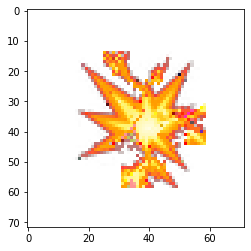

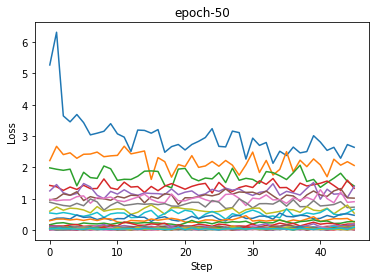

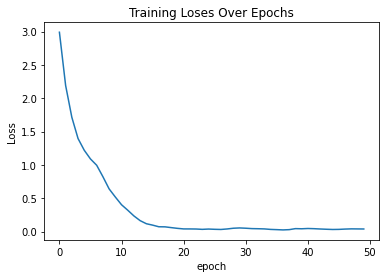

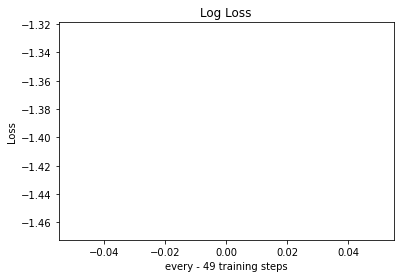

training epochs:  33%|███▎      | 99/300 [34:40<1:08:43, 20.51s/it]

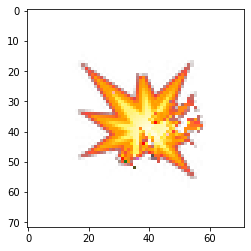

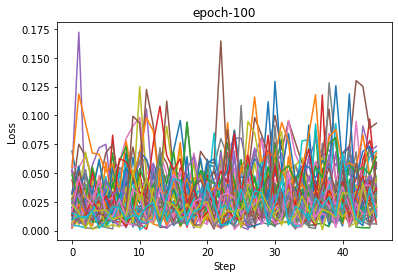

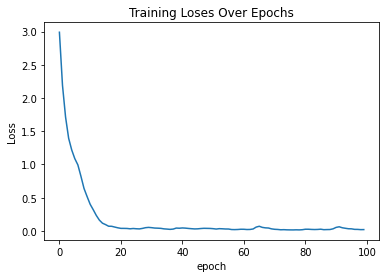

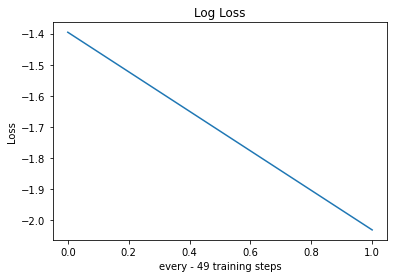

training epochs:  50%|████▉     | 149/300 [52:35<51:43, 20.55s/it]

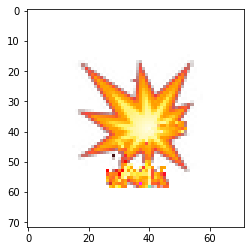

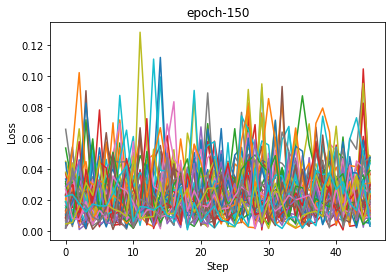

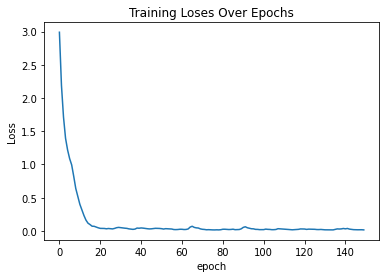

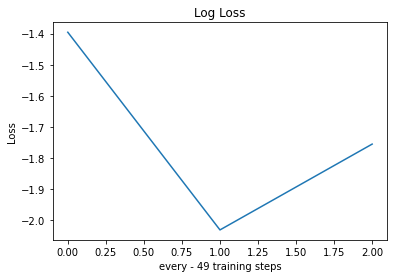

training epochs:  66%|██████▋   | 199/300 [1:10:30<34:36, 20.56s/it]

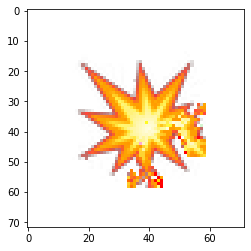

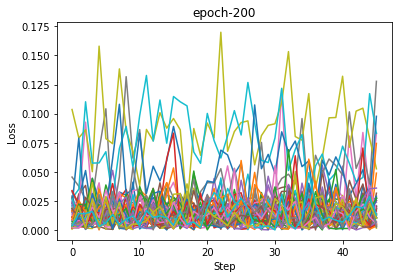

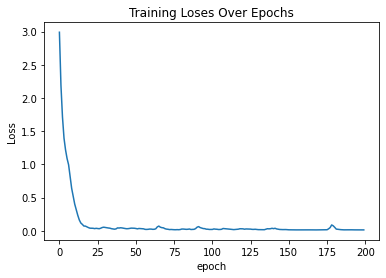

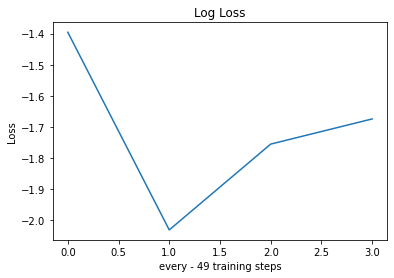

training epochs:  83%|████████▎ | 249/300 [1:28:25<17:28, 20.56s/it]

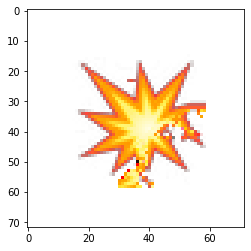

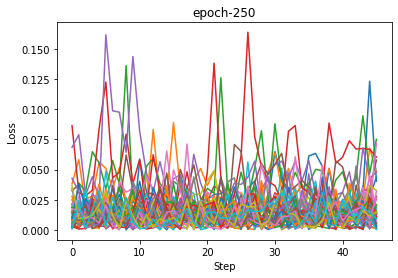

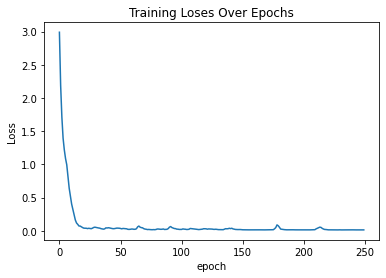

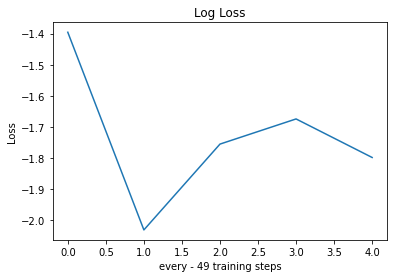

training epochs: 100%|█████████▉| 299/300 [1:46:21<00:20, 20.54s/it]

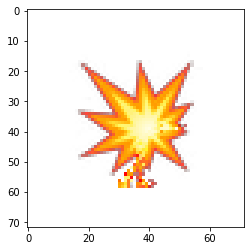

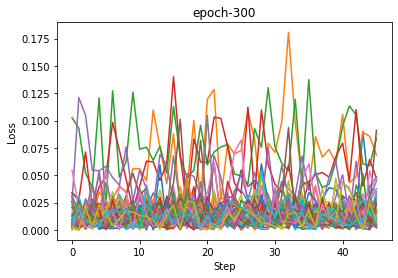

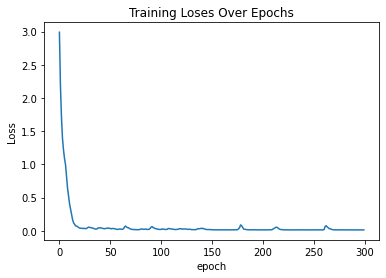

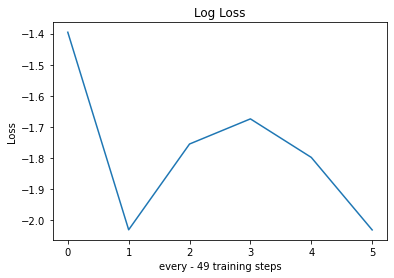

training epochs: 100%|██████████| 300/300 [1:47:29<00:00, 21.50s/it]


In [19]:
#@title Un-Ordered Training!!!!! { vertical-output: true}

# training
log_loss = []

TRAIN_ON=True 
EVAL_EVERY=50
VISUALISE_EVERY = 50

next_token_loss = [['EPOCH', 'STEP', 'LOSS']]
epoch_losses = []
epoch_mean_losses = []

training_dataset, EVAL_STEPS = create_training_dataset()
print('LEN DATASET', len(training_dataset))
data_loader = DataLoader(dataset=training_dataset, batch_size=64, shuffle=True)

TRAINING_STEPS = EPOCHS

for i in tqdm.tqdm(range(1,TRAINING_STEPS + 1), mininterval=10., desc='training epochs'):
    if (TRAIN_ON):
      losses = []    
      enc.train(), dec.train()
      for batch_i , (src, tgt, src_mask, tgt_mask) in enumerate(data_loader):
        context = enc(src, input_mask = src_mask)
        loss = dec(tgt, context = context, input_mask = tgt_mask, context_mask = src_mask, return_loss = True)
        loss.backward()
        loss_value = loss.item()
        next_token_loss.append([i, batch_i, loss_value])
        losses.append(loss_value)
        optim.step()
        optim.zero_grad()

      epoch_mean_losses.append(sum(losses)/len(losses)  )
      epoch_losses.append(losses)

    # Generate:
    if (EVAL_STEPS > 0 and i % EVAL_EVERY == 0):
      x = get_X0()

      x = generate(enc, dec, x, EVAL_STEPS)

      un_clean_loss = t_loss_f(x)
      lo_n = loss_score(un_clean_loss)
      log_loss.append(lo_n)

      if (lo_n < -4):
        print('Early threshold Exit..')
        break

    # Visualise progress
    if (i % VISUALISE_EVERY == 0):
      visualize_batched(x.detach().clone())
      plt.figure()
      for ep, l in enumerate(epoch_losses):
        plt.plot(l, label=f'EPOCH-{i+ep}')

      plt.xlabel("Step")
      plt.ylabel("Loss")
      plt.title(f"epoch-{i}")
      # plt.legend()
      plt.show()
      epoch_losses = []

      plt.figure()
      plt.plot(epoch_mean_losses)

      plt.xlabel("epoch")
      plt.ylabel("Loss")
      plt.title(f"Training Loses Over Epochs")
      plt.show()

      if (len(log_loss) > 0):
        plt.figure()
        plt.plot(log_loss, label=f'EPOCH-{i+ep}')

        plt.xlabel(f"every - {EVAL_EVERY-1} training steps")
        plt.ylabel("Loss")
        plt.title("Log Loss")
        plt.show()

      
    # TODO - produced x - calculate l2 loss and add to log loss - need alignment first

In [20]:
#@title Save Models { vertical-output: true}
import time

SAVE_MODEL= True
if (SAVE_MODEL):
  ts = str(time.time()).split('.')[0]
  current_t = ts

  ENC_FILE = f'./enc-{str(current_t)}.pth'
  DEC_FILE = f'./dec-{str(current_t)}.pth'

  torch.save(enc, ENC_FILE)
  drive_path = f'/content/gdrive/My Drive/KCL CS/Year 4/PRJ/models/{ENC_FILE}'
  shutil.copyfile(ENC_FILE, drive_path)

  torch.save(dec, DEC_FILE)
  drive_path = f'/content/gdrive/My Drive/KCL CS/Year 4/PRJ/models/{DEC_FILE}'
  shutil.copyfile(DEC_FILE, drive_path)

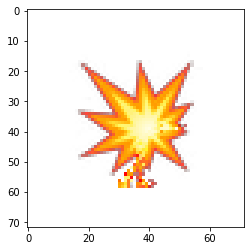

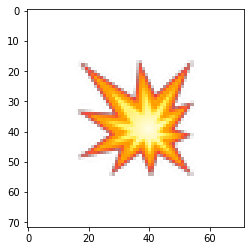

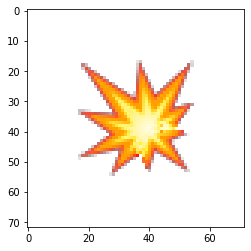

TLOSS -2.031837
TLOSS CLEAN -2.5804265


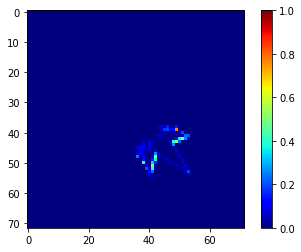

In [21]:
# HELPER BLOCK? - Visualises last x again

cleaned_x =  cleaned_x_long(x, loss_target_mask) 

visualize_batched(x)
visualize_batched(pad_target[None,...].long())
visualize_batched(cleaned_x)

to_diff = cleaned_x #cleaned_x

loss = t_loss_f(to_diff)
plot_loss_diff(loss)

print('TLOSS', loss_score(t_loss_f(x)) )
print('TLOSS CLEAN',loss_score(t_loss_f(x, clean=True)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


-2.5622225
-2.61724
-6.459098
-2.6590707
-2.6018665
-2.5362115
-2.601336
-2.5956511
-6.0725107
-2.5051613
-2.484844
-5.438369
-2.5766168
-2.522697
-2.5696783
-2.761381
-2.6304848
-2.626351
-4.532818
-6.459098

-6.459098


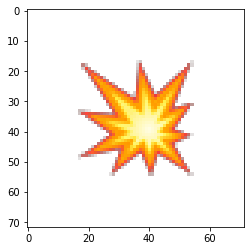

In [23]:
#@title Multiple Image Generation { vertical-output: true}

NUMBER_TO_GENERATE = 20

best_gen, best_score = None, float('inf')

GEN_FROM_TARGET = False

for _ in tqdm.auto.tqdm(range(NUMBER_TO_GENERATE), mininterval=1., desc='generating images'):
  GEN_FROM = cleaned_x_long(pad_target,loss_target_mask) if GEN_FROM_TARGET else get_X0()

  x = generate(enc, dec, GEN_FROM, EVAL_STEPS, disable=True)
  score = loss_score(t_loss_f(x, clean=True))
  if score  < best_score:
    best_score = score
    best_gen = x
  print(score)

print(best_score)
visualize_batched(cleaned_x_long(best_gen, loss_target_mask))

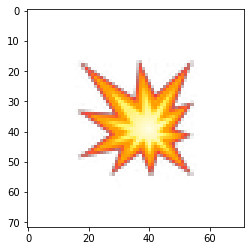

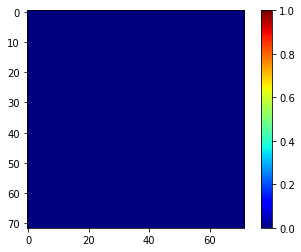

In [24]:
visualize_batched(best_gen)
plot_loss_diff(t_loss_f(best_gen, clean=True))



In [25]:
#@title Persistance Tests { vertical-output: true}

START_FROM_TARGET = True  # False will start from best generated, True from target position. 
CLEANED_BEST_GEN = True

ROUNDS = 3 
SCORE_EVERY = 10
# TOTAL STEPS = ROUNDS * SCORE_EVERY

c_scores = []
uc_scores = []

# use best generated or use target state? 
bg = cleaned_x_long(best_gen, loss_target_mask) if CLEANED_BEST_GEN else best_gen
x = cleaned_x_long(pad_target,loss_target_mask) if START_FROM_TARGET else bg

for _ in tqdm.auto.tqdm(range(ROUNDS), mininterval=1., desc='persistent experiementing...'):
  x = generate(enc, dec, x, SCORE_EVERY, disable=True)
  unmasked_score = loss_score(t_loss_f(x, clean=False))
  uc_scores.append(unmasked_score)

  masked_score = loss_score(t_loss_f(x, clean=True))
  c_scores.append(masked_score)

print(c_scores)
print(uc_scores)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



[-6.459098, -5.8795767, -5.8795767]
[-1.7616256, -1.2731549, -1.0252137]


In [26]:
print(c_scores)
print(uc_scores)


[-6.459098, -5.8795767, -5.8795767]
[-1.7616256, -1.2731549, -1.0252137]


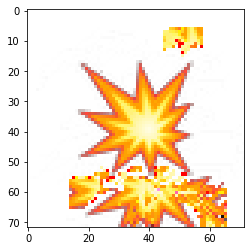

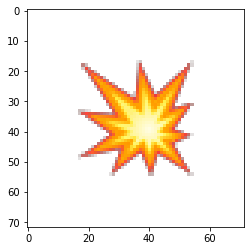

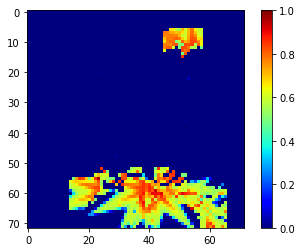

In [27]:
visualize_batched(x)
visualize_batched(cleaned_x_long(x, loss_target_mask))


loss = t_loss_f(x)
plot_loss_diff(loss)